In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 12.9 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.25
batch_size_value = 64
n_repeats = 3
n_epochs = 50
lr = 1e-3
# noise = 'topological'
noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:06<00:00, 1588.63it/s]



gaussian noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 1555.48it/s]


gaussian noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

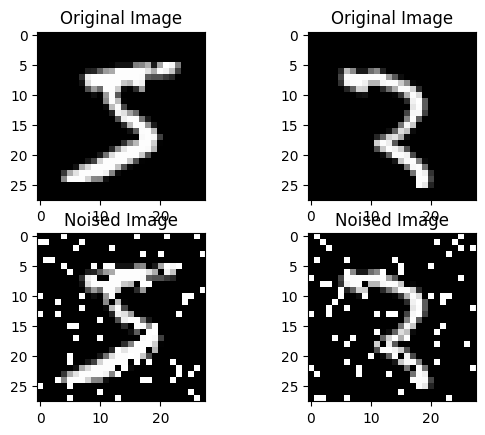

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

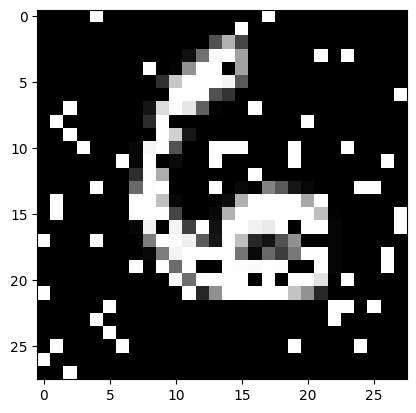

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

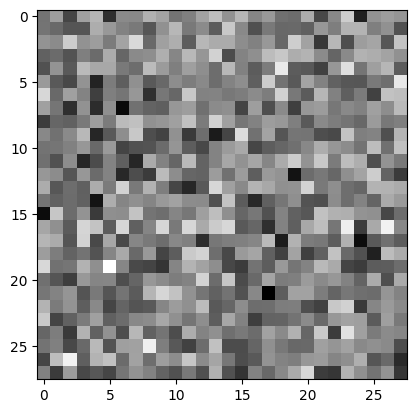

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(743.0777, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

5165.55615234375

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0156,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


  0 7650.8564 5234.4346


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


  1 6436.9189 5186.3979


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


  2 6067.9902 5187.9307


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


  3 5883.6509 5182.6777


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


  4 5777.9443 5175.6802


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


  5 5697.7378 5163.2490


100%|██████████| 157/157 [02:23<00:00,  1.09it/s]


  6 5645.5674 5152.0205


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


  7 5609.5483 5139.9692


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


  8 5586.6836 5130.5630


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


  9 5572.0098 5122.0469


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 10 5559.4243 5116.5166


100%|██████████| 157/157 [02:23<00:00,  1.09it/s]


 11 5548.8965 5112.2007


100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


 12 5541.9688 5106.9707


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


 13 5533.8892 5104.2915


100%|██████████| 157/157 [02:24<00:00,  1.08it/s]


 14 5527.3677 5102.8247


100%|██████████| 157/157 [02:23<00:00,  1.10it/s]


 15 5521.6943 5102.7939


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 16 5519.5698 5099.4966


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 17 5515.7983 5098.7358


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 18 5512.2832 5097.4468


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 19 5508.9180 5097.0571


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 20 5507.2026 5095.2349


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


 21 5503.9629 5094.6592


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 22 5500.2603 5093.7954


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 23 5500.5078 5092.3267


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


 24 5497.5635 5091.3711


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 25 5496.3545 5089.7510


100%|██████████| 157/157 [02:23<00:00,  1.09it/s]


 26 5495.4536 5091.4141


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


 27 5494.3096 5090.7339


100%|██████████| 157/157 [02:24<00:00,  1.08it/s]


 28 5491.8232 5088.4570


100%|██████████| 157/157 [02:23<00:00,  1.10it/s]


 29 5491.1250 5090.0205


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 30 5490.0342 5089.7354


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 31 5488.0151 5087.0967


100%|██████████| 157/157 [02:21<00:00,  1.11it/s]


 32 5485.7979 5086.6396


100%|██████████| 157/157 [02:23<00:00,  1.10it/s]


 33 5486.2095 5086.0259


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 34 5483.5225 5087.5806


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


 35 5482.6489 5084.0908


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


 36 5482.6084 5083.3433


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 37 5480.9365 5085.3545


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 38 5479.9937 5085.5542


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 39 5479.3555 5085.3979


100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


 40 5477.9536 5083.7812


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 41 5477.2285 5084.2466


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 42 5476.8130 5082.6489


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


 43 5475.3511 5082.5767


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 44 5473.8721 5082.6338


100%|██████████| 157/157 [02:23<00:00,  1.09it/s]


 45 5473.1367 5082.1128


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 46 5473.0220 5082.8242


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


 47 5472.4834 5080.3955


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


 48 5471.1973 5081.0752


100%|██████████| 157/157 [02:21<00:00,  1.11it/s]


 49 5468.9233 5079.8818

  2 MSE    Topo  


100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


  0 7644.8916 5258.7642


100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


  1 6390.6528 5193.3975


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


  2 6057.5830 5205.3228


100%|██████████| 157/157 [02:31<00:00,  1.03it/s]


  3 5858.6670 5198.5693


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


  4 5748.3608 5184.9307


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


  5 5674.6821 5165.3916


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


  6 5629.1543 5146.6836


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


  7 5598.4990 5136.2148


100%|██████████| 157/157 [02:19<00:00,  1.12it/s]


  8 5576.6685 5124.3066


100%|██████████| 157/157 [02:24<00:00,  1.08it/s]


  9 5561.3198 5118.2905


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 10 5549.0723 5114.1499


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


 11 5539.9316 5111.5269


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


 12 5535.4556 5108.2246


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


 13 5528.1763 5106.6177


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 14 5523.5918 5103.7393


100%|██████████| 157/157 [02:23<00:00,  1.10it/s]


 15 5519.8486 5100.2236


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


 16 5516.9204 5100.1089


100%|██████████| 157/157 [02:21<00:00,  1.11it/s]


 17 5512.1777 5099.6689


100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


 18 5510.8574 5097.4688


100%|██████████| 157/157 [02:19<00:00,  1.12it/s]


 19 5507.6011 5096.4912


100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


 20 5505.1655 5097.0776


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


 21 5501.9844 5096.0615


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


 22 5500.3989 5094.3457


100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


 23 5499.1846 5092.4180


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


 24 5496.5249 5091.1929


100%|██████████| 157/157 [02:30<00:00,  1.05it/s]


 25 5494.5479 5091.4370


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 26 5494.6270 5093.5728


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 27 5493.1309 5092.3257


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 28 5490.0493 5091.9751


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 29 5488.4990 5088.7803


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 30 5487.9497 5089.2578


100%|██████████| 157/157 [02:23<00:00,  1.10it/s]


 31 5485.0708 5089.0591


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 32 5484.8853 5089.5835


100%|██████████| 157/157 [02:30<00:00,  1.05it/s]


 33 5483.7852 5089.2534


100%|██████████| 157/157 [02:31<00:00,  1.03it/s]


 34 5481.6802 5086.4277


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 35 5479.3774 5084.8027


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 36 5480.0493 5086.7036


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 37 5477.5181 5085.6768


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


 38 5477.2490 5087.2461


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 39 5475.9985 5086.5239


100%|██████████| 157/157 [02:30<00:00,  1.05it/s]


 40 5474.1323 5086.1616


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 41 5472.9150 5085.5688


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 42 5470.7183 5083.8066


100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


 43 5469.9126 5084.8838


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


 44 5469.4468 5084.8530


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


 45 5467.6802 5083.1201


100%|██████████| 157/157 [02:27<00:00,  1.07it/s]


 46 5466.4678 5083.0522


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 47 5464.6602 5084.6641


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 48 5463.4932 5083.7227


100%|██████████| 157/157 [02:33<00:00,  1.03it/s]


 49 5462.2363 5082.1694

  3 MSE    Topo  


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


  0 7716.9233 5247.6909


100%|██████████| 157/157 [02:37<00:00,  1.01s/it]


  1 6458.8867 5196.1973


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


  2 6082.7773 5202.5190


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


  3 5885.8359 5190.8740


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


  4 5775.9805 5177.0508


100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


  5 5706.1538 5167.5459


100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


  6 5655.4946 5157.0029


100%|██████████| 157/157 [02:27<00:00,  1.07it/s]


  7 5615.7798 5141.5088


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


  8 5590.4043 5127.5645


100%|██████████| 157/157 [02:30<00:00,  1.05it/s]


  9 5574.1973 5118.4644


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 10 5562.8027 5112.8198


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 11 5552.3130 5108.6411


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 12 5546.3350 5107.0869


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 13 5539.6650 5104.5449


100%|██████████| 157/157 [02:34<00:00,  1.01it/s]


 14 5536.1958 5104.1074


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


 15 5530.3066 5100.0742


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 16 5527.5444 5098.8877


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


 17 5523.8745 5097.2446


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 18 5523.8330 5097.8853


100%|██████████| 157/157 [02:40<00:00,  1.02s/it]


 19 5520.7461 5095.8438


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


 20 5518.0464 5095.9048


100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


 21 5515.1177 5092.7856


100%|██████████| 157/157 [02:42<00:00,  1.03s/it]


 22 5512.7007 5092.3647


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


 23 5510.6436 5092.4668


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 24 5508.5356 5090.9517


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 25 5506.8296 5090.3242


100%|██████████| 157/157 [02:31<00:00,  1.03it/s]


 26 5503.8247 5088.6367


100%|██████████| 157/157 [02:24<00:00,  1.08it/s]


 27 5501.6997 5089.7231


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


 28 5500.3608 5087.6182


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


 29 5498.6387 5088.5303


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 30 5496.8232 5088.1753


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 31 5494.7661 5086.6152


100%|██████████| 157/157 [02:25<00:00,  1.08it/s]


 32 5493.3208 5088.0361


100%|██████████| 157/157 [02:23<00:00,  1.09it/s]


 33 5491.6304 5085.2500


100%|██████████| 157/157 [02:18<00:00,  1.14it/s]


 34 5489.9946 5086.7007


100%|██████████| 157/157 [02:24<00:00,  1.08it/s]


 35 5487.7603 5085.6855


100%|██████████| 157/157 [02:23<00:00,  1.09it/s]


 36 5487.1035 5085.8770


100%|██████████| 157/157 [02:21<00:00,  1.11it/s]


 37 5484.3232 5083.6074


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 38 5484.0566 5084.6187


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 39 5481.3232 5082.5010


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


 40 5480.4165 5083.6045


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 41 5480.3560 5083.2764


100%|██████████| 157/157 [02:37<00:00,  1.01s/it]


 42 5478.3311 5084.7817


100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


 43 5476.6807 5084.0269


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 44 5474.6123 5082.8032


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 45 5475.3481 5083.4556


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 46 5472.1846 5082.4688


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 47 5471.1602 5081.9966


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 48 5470.3369 5085.0894


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]

 49 5467.5435 5081.3071

CPU times: user 12h 14min 9s, sys: 39.1 s, total: 12h 14min 48s
Wall time: 6h 11min 18s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

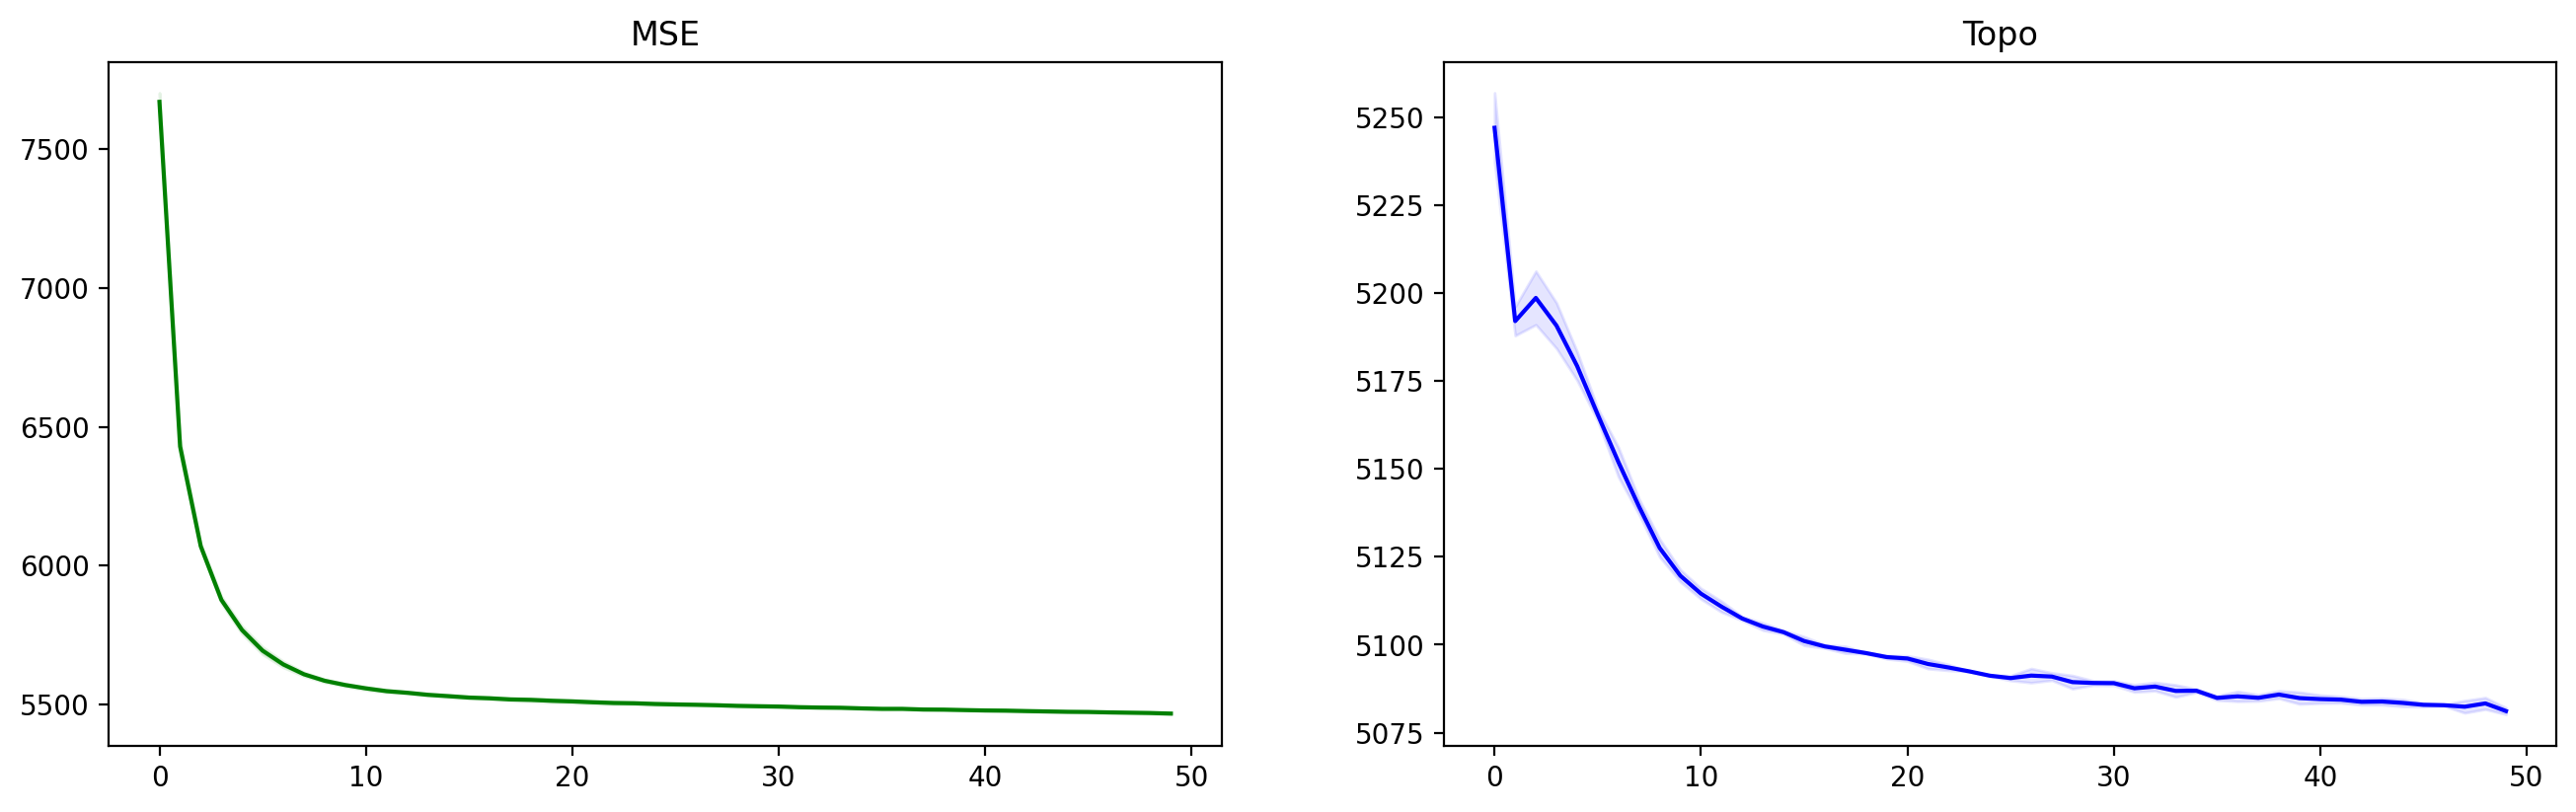

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

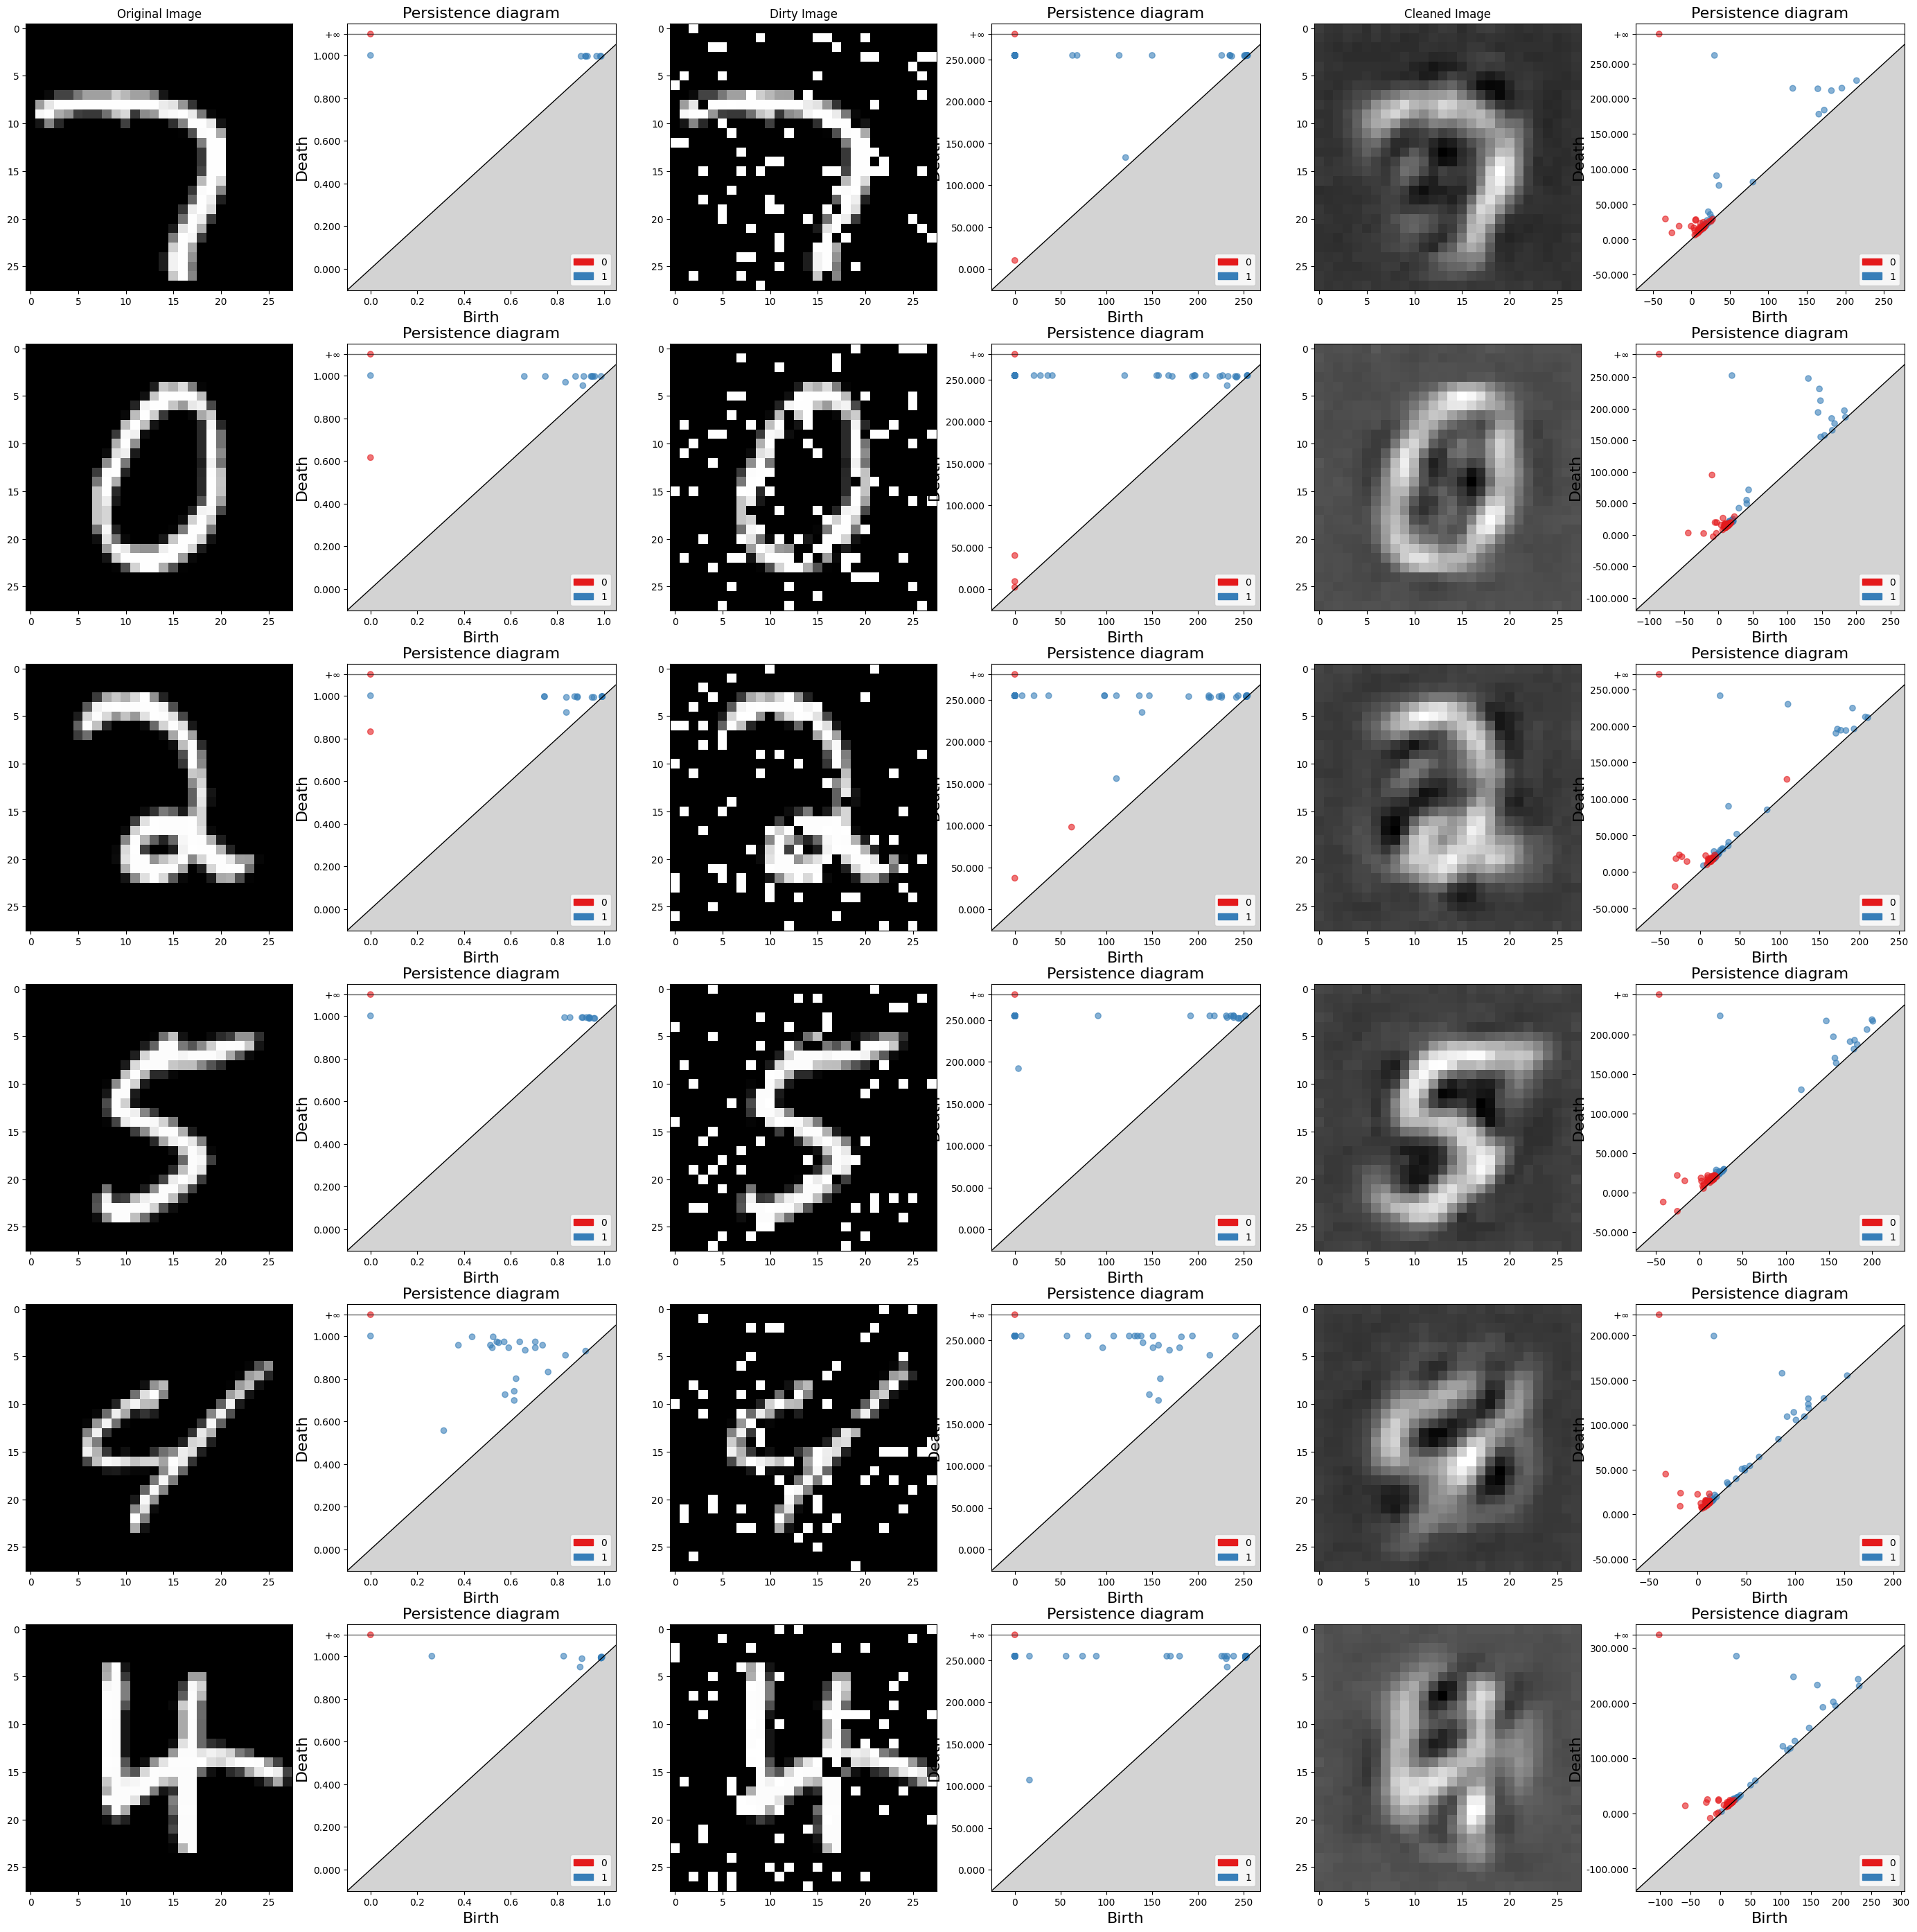

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[7650.85644531 5234.43457031]
  [6436.91894531 5186.39794922]
  [6067.99023438 5187.93066406]
  [5883.65087891 5182.67773438]
  [5777.94433594 5175.68017578]
  [5697.73779297 5163.24902344]
  [5645.56738281 5152.02050781]
  [5609.54833984 5139.96923828]
  [5586.68359375 5130.56298828]
  [5572.00976562 5122.046875  ]
  [5559.42431641 5116.51660156]
  [5548.89648438 5112.20068359]
  [5541.96875    5106.97070312]
  [5533.88916016 5104.29150391]
  [5527.36767578 5102.82470703]
  [5521.69433594 5102.79394531]
  [5519.56982422 5099.49658203]
  [5515.79833984 5098.73583984]
  [5512.28320312 5097.44677734]
  [5508.91796875 5097.05712891]
  [5507.20263672 5095.23486328]
  [5503.96289062 5094.65917969]
  [5500.26025391 5093.79541016]
  [5500.5078125  5092.32666016]
  [5497.56347656 5091.37109375]
  [5496.35449219 5089.75097656]
  [5495.45361328 5091.4140625 ]
  [5494.30957031 5090.73388672]
  [5491.82324219 5088.45703125]
  [5491.125      5090.02050781]
  [5490.03417969 5089.73535156]
  [5488.